In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/Aditya1Jhaveri/cervix-cancer-Deep-learning.git

Cloning into 'cervix-cancer-Deep-learning'...
remote: Enumerating objects: 53303, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 53303 (delta 26), reused 41 (delta 7), pack-reused 53234
Receiving objects: 100% (53303/53303), 1.75 GiB | 40.41 MiB/s, done.
Resolving deltas: 100% (232/232), done.
Updating files: 100% (50901/50901), done.


In [3]:
import tensorflow as tf
from keras.applications import ResNet101V2
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization,Flatten
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing
from keras.utils import to_categorical



# Set your data directories and parameters
train_data_dir = '/content/cervix-cancer-Deep-learning/NEW_DATASET/train'
test_data_dir = '/content/cervix-cancer-Deep-learning/NEW_DATASET/test'
val_data_dir = '/content/cervix-cancer-Deep-learning/NEW_DATASET/validation'


img_width, img_height = 224, 224
batch_size = 16
base_learning_rate = 0.001  # Adjust as needed

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Data preprocessing for test
test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Load the data using data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Automatically one-hot encodes labels
    shuffle=True  # Shuffle the data
)
print(f"Found {train_generator.samples} images belonging to {len(train_generator.class_indices)} classes in train dataset.")

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Automatically one-hot encodes labels
    shuffle=False  # No need to shuffle test data
)
print(f"Found {test_generator.samples} images belonging to {len(test_generator.class_indices)} classes in test dataset.")

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Automatically one-hot encodes labels
    shuffle=False  # No need to shuffle test data
)
print(f"Found {val_generator.samples} images belonging to {len(val_generator.class_indices)} classes in validation dataset.")


Found 12110 images belonging to 7 classes.
Found 12110 images belonging to 7 classes in train dataset.
Found 2083 images belonging to 7 classes.
Found 2083 images belonging to 7 classes in test dataset.
Found 3111 images belonging to 7 classes.
Found 3111 images belonging to 7 classes in validation dataset.


In [4]:
# Load the ResNet101V2 model
base_model = ResNet101V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


# Add your custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
x = Flatten()(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
# x = BatchNormalization()(x)

predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


base_model.trainable = True

set_trainable = False

for layer in base_model.layers:
  if layer.name == 'conv4_block1_preact_bn':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in base_model.layers:
  print(layer.name,layer.trainable)


171317808/171317808 [==============================] - 1s 0us/step
input_1 False
conv1_pad False
conv1_conv False
pool1_pad False
pool1_pool False
conv2_block1_preact_bn False
conv2_block1_preact_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_pad False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_out False
conv2_block2_preact_bn False
conv2_block2_preact_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_pad False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_out False
conv2_block3_preact_bn False
conv2_block3_preact_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_pad False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
max_pooling2d Fals

In [5]:
model.summary();

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [6]:
# Compile the model after unfreezing layers for fine-tuning
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # Use categorical_crossentropy
    optimizer=RMSprop(learning_rate=base_learning_rate/10),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]  # Use CategoricalAccuracy
)

# Set up callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.2, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and learning rate reduction
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=25,
    validation_data=val_generator,
    validation_steps=len(val_generator) // batch_size,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/25
756/756 [==============================] - 293s 330ms/step - loss: 1.2260 - accuracy: 0.5336 - val_loss: 1.3852 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/25
756/756 [==============================] - 244s 323ms/step - loss: 0.8863 - accuracy: 0.6630 - val_loss: 0.7608 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 3/25
756/756 [==============================] - 247s 327ms/step - loss: 0.7262 - accuracy: 0.7237 - val_loss: 0.5991 - val_accuracy: 0.8177 - lr: 1.0000e-04
Epoch 4/25
756/756 [==============================] - 246s 325ms/step - loss: 0.6080 - accuracy: 0.7741 - val_loss: 0.2901 - val_accuracy: 0.9219 - lr: 1.0000e-04
Epoch 5/25
756/756 [==============================] - 243s 321ms/step - loss: 0.5226 - accuracy: 0.8099 - val_loss: 0.3617 - val_accuracy: 0.9167 - lr: 1.0000e-04
Epoch 6/25
756/756 [==============================] - 249s 330ms/step - loss: 0.4675 - accuracy: 0.8299 - val_loss: 0.4670 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 7/25
756/756 [==

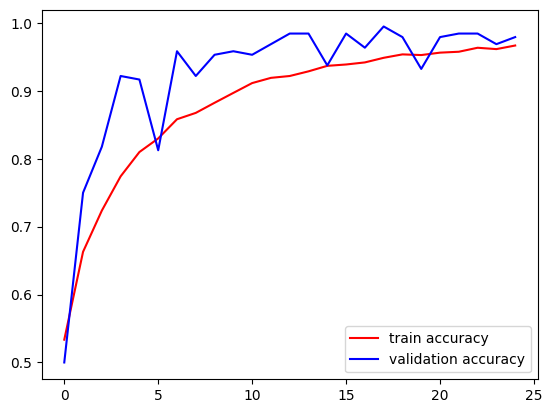

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='validation accuracy')
plt.legend()
plt.show()

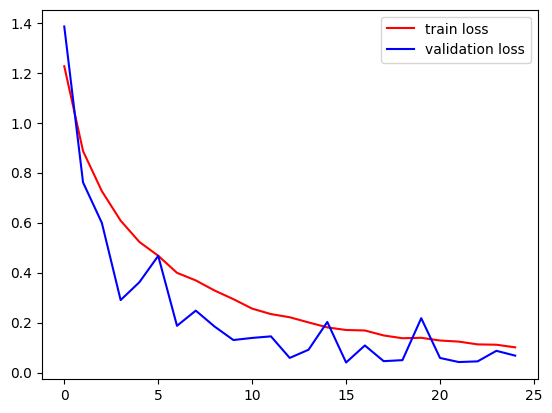

In [9]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.plot(history.history['loss'], color='red', label='train loss')
plt.plot(history.history['val_loss'], color='blue', label='validation loss')
plt.legend()
plt.show()

In [10]:
train_loss, train_accuracy = model.evaluate(train_generator)

print(f'Train accuracy: {train_accuracy:.4f}')

757/757 [==============================] - 192s 254ms/step - loss: 0.0635 - accuracy: 0.9825
Train accuracy: 0.9825


In [11]:
# Evaluate the model on the test data using the test generator
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test accuracy: {test_accuracy:.4f}')

131/131 [==============================] - 34s 256ms/step - loss: 0.0736 - accuracy: 0.9746
Test accuracy: 0.9746


131/131 [==============================] - 45s 320ms/step


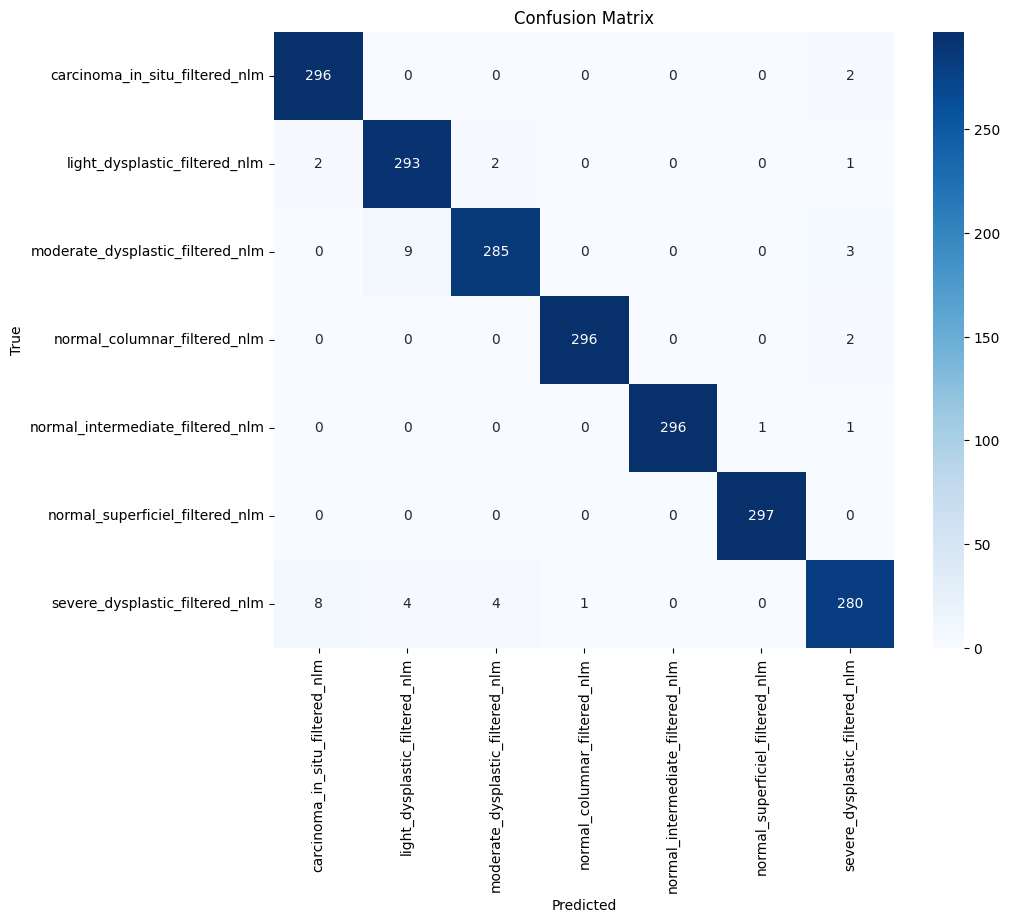

                              Class  Precision    Recall  F1 Score
0    carcinoma_in_situ_filtered_nlm   0.967320  0.993289  0.980132
1     light_dysplastic_filtered_nlm   0.957516  0.983221  0.970199
2  moderate_dysplastic_filtered_nlm   0.979381  0.959596  0.969388
3      normal_columnar_filtered_nlm   0.996633  0.993289  0.994958
4  normal_intermediate_filtered_nlm   1.000000  0.993289  0.996633
5   normal_superficiel_filtered_nlm   0.996644  1.000000  0.998319
6    severe_dysplastic_filtered_nlm   0.968858  0.942761  0.955631


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Make Predictions
y_pred = model.predict(test_generator)

# Convert Predictions and True Labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes

# Create the Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)


# Create a dictionary to map class indices to class names
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}


# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Create a list of class names
class_names_list = [class_names[i] for i in range(len(class_indices))]

# Create a DataFrame to organize the results
results_df = pd.DataFrame({
    'Class': class_names_list,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Print the results table
print(results_df)


In [ ]:
# Save the model with custom layers and weights
model.save('ResNet101V2_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# from keras.applications import ResNet50V2

# Load the model
new_model = tf.keras.models.load_model('/content/drive/MyDrive/ResNet50V2_model.h5')

# Compile the model after unfreezing layers for fine-tuning
# new_model.compile(
#     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # Use categorical_crossentropy
#     optimizer=RMSprop(learning_rate=base_learning_rate/10),
#     metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]  # Use CategoricalAccuracy
# )

# # Set up callbacks
# reduce_lr = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.2, min_lr=1e-6)
# early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# # Train the new_model with early stopping and learning rate reduction
# history = new_model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     epochs=50,
#     initial_epoch=25,
#     validation_data=val_generator,
#     validation_steps=len(val_generator) // batch_size,
#     callbacks=[reduce_lr, early_stopping]
# )


In [ ]:
train_loss, train_accuracy = new_model.evaluate(train_generator)

print(f'Train accuracy: {train_accuracy:.4f}')

757/757 [==============================] - 233s 294ms/step - loss: 0.0354 - accuracy: 0.9888
Train accuracy: 0.9888


In [ ]:
# Evaluate the model on the test data using the test generator
test_loss, test_accuracy = new_model.evaluate(test_generator)

print(f'Test accuracy: {test_accuracy:.4f}')

131/131 [==============================] - 39s 295ms/step - loss: 0.0670 - accuracy: 0.9794
Test accuracy: 0.9794


131/131 [==============================] - 42s 290ms/step


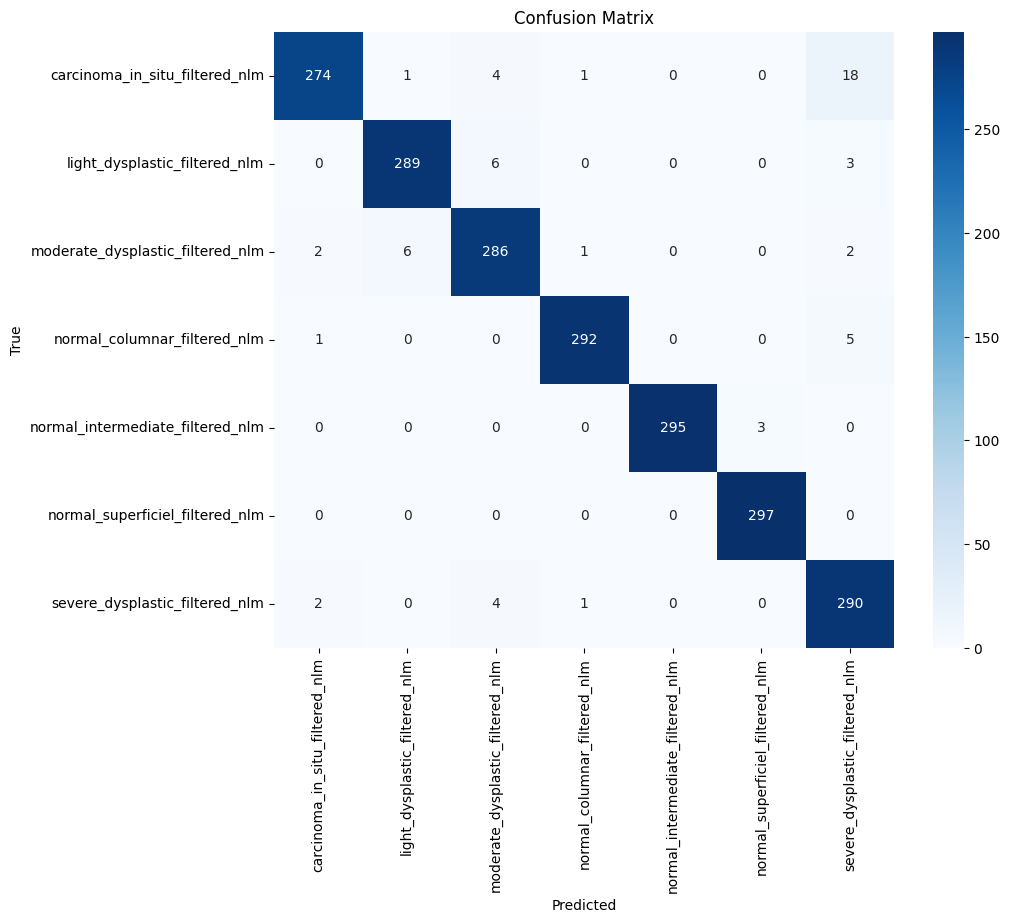

                              Class  Precision    Recall  F1 Score
0    carcinoma_in_situ_filtered_nlm   0.982079  0.919463  0.949740
1     light_dysplastic_filtered_nlm   0.976351  0.969799  0.973064
2  moderate_dysplastic_filtered_nlm   0.953333  0.962963  0.958124
3      normal_columnar_filtered_nlm   0.989831  0.979866  0.984823
4  normal_intermediate_filtered_nlm   1.000000  0.989933  0.994941
5   normal_superficiel_filtered_nlm   0.990000  1.000000  0.994975
6    severe_dysplastic_filtered_nlm   0.911950  0.976431  0.943089


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Make Predictions
y_pred = new_model.predict(test_generator)

# Convert Predictions and True Labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes

# Create the Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)


# Create a dictionary to map class indices to class names
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}


# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Create a list of class names
class_names_list = [class_names[i] for i in range(len(class_indices))]

# Create a DataFrame to organize the results
results_df = pd.DataFrame({
    'Class': class_names_list,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Print the results table
print(results_df)


1/1 [==============================] - 0s 61ms/step


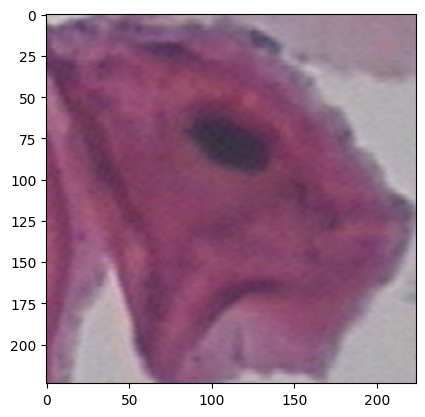

Predicted Class: normal_intermediate_filtered_nlm
Non-cancerous


In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define the determine_cancerous function
def determine_cancerous(class_name):
    cancerous_classes = {
        'carcinoma_in_situ_filtered_nlm': True,
        'light_dysplastic_filtered_nlm': True,
        'moderate_dysplastic_filtered_nlm': True,
        'normal_columnar_filtered_nlm': False,
        'normal_intermediate_filtered_nlm':False,
        'normal_superficiel_filtered_nlm': False,
        'severe_dysplastic_filtered_nlm': True,
    }

    return cancerous_classes.get(class_name, None)

# Load and preprocess a sample image
image_path = '/content/cervix-cancer-Deep-learning/Herlev Dataset resized/test/normal_superficiel/157183412-157183638-001 - Copy (2).BMP'
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # rescale

# Make a prediction
prediction = new_model.predict(img_array)

# Convert the prediction to class name
class_index = np.argmax(prediction)
class_name = list(test_generator.class_indices.keys())[class_index]

plt.imshow(img)
plt.show()

# Print the predicted class name
print(f'Predicted Class: {class_name}')

# Determine if it's cancerous or not
is_cancerous = determine_cancerous(class_name)



# Print whether it's cancerous or not
if is_cancerous is not None:
    if is_cancerous:
        print('Cancerous')
    else:
        print('Non-cancerous')
else:
    print('Class not found in dictionary')


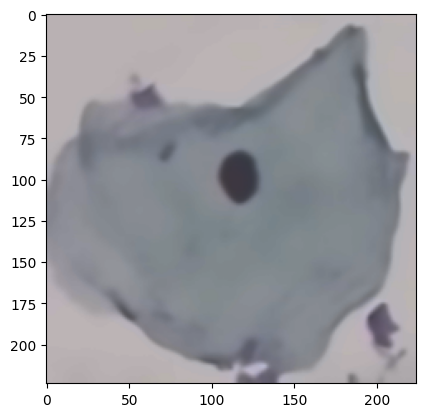

1/1 [==============================] - 0s 117ms/step
Predicted Class: normal_superficiel_filtered_nlm
Non-cancerous


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the NLM filter function
def nlm_filter(image):
    filtered_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)  # Adjust parameters as needed
    return filtered_image


# Define the determine_cancerous function
def determine_cancerous(class_name):
    cancerous_classes = {
        'carcinoma_in_situ_filtered_nlm': True,
        'light_dysplastic_filtered_nlm': True,
        'moderate_dysplastic_filtered_nlm': True,
        'normal_columnar_filtered_nlm': False,
        'normal_intermediate_filtered_nlm': False,
        'normal_superficiel_filtered_nlm': False,
        'severe_dysplastic_filtered_nlm': True,
    }
    return cancerous_classes.get(class_name, None)

# Load and preprocess a sample image
image_path = '/content/cervix-cancer-Deep-learning/Herlev Dataset resized/test/normal_superficiel/157222737-157222750-002 - Copy (2).BMP'  # Replace with the actual path to your image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB


filtered_image = nlm_filter(img_rgb)

# Display the filtered image
plt.imshow(filtered_image)
# plt.title('Filtered Image')
plt.show()

# Rescale and expand dimensions
img_array = np.expand_dims(filtered_image / 255., axis=0)

# Make a prediction
prediction = new_model.predict(img_array)

# Convert the prediction to class name
class_index = np.argmax(prediction)
class_name = list(test_generator.class_indices.keys())[class_index]

# Print the predicted class name
print(f'Predicted Class: {class_name}')

# Determine if it's cancerous or not
is_cancerous = determine_cancerous(class_name)

# Print whether it's cancerous or not
if is_cancerous is not None:
    if is_cancerous:
        print('Cancerous')
    else:
        print('Non-cancerous')
else:
    print('Class not found in dictionary')
